In [11]:
#Zip Datei entpacken
import zipfile
import os
import tifffile
import glob

# Path to our Zip file with the training data
zip_path = "C:/Users/hendr/Desktop/ML_Seminar/MoNuSAC_images_and_annotations.zip"

# Paths to the data and the masks
extract_dir_data = "data"
extract_dir_masks  = "MoNuSAC_masks" #load masks instead of datasets (generatet via binary_mask_generation)

# Ordner erstellen, falls nicht vorhanden
#os.makedirs(extract_dir_data, exist_ok=True)

# ZIP entpacken
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    #zip_ref.extractall(extract_dir_data)

# Get the tif files
tif_files_data = glob.glob(os.path.join(extract_dir_data,"**", "*.tif"), recursive=True)
print(f"Found TIFF-data: {len(tif_files_data)}")

tif_files_masks = glob.glob(os.path.join(extract_dir_masks,"**", "*.tif"), recursive=True)
print(f"Found TIFF-Masks: {len(tif_files_masks)}")

Found TIFF-data: 209
Found TIFF-Masks: 394


Loaded number of images: 209


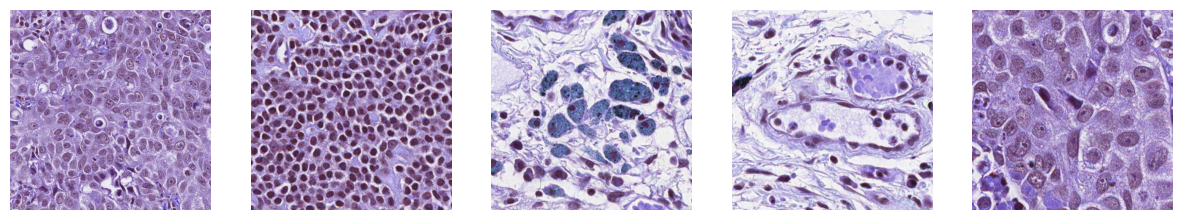

In [12]:
import matplotlib.pyplot as plt

images_original = []
# Ensure we only try to load valid files
valid_files = [f for f in tif_files_data if f.endswith(('.tif', '.tiff'))]

for f in valid_files:
    try:
        # tifffile returns a numpy array directly
        img = tifffile.imread(f)
        images_original.append(img)
    except Exception as e:
        print(f"Error loading {f}: {e}")

print("Loaded number of images:", len(images_original))

if len(images_original) > 0:
    plt.figure(figsize=(15,3))
    # Limit to 5 or the length of images, whichever is smaller
    count = min(5, len(images_original))
    
    for i in range(count):
        plt.subplot(1, 5, i+1)
        plt.imshow(images_original[i]) # Matplotlib handles numpy arrays automatically
        plt.axis("off")
    plt.show()

Loaded number of images: 394


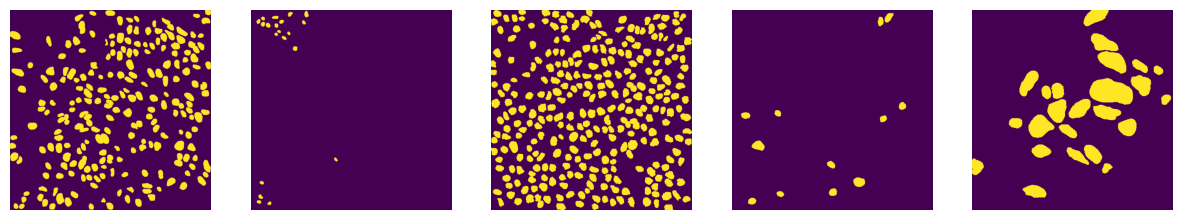

In [13]:
import matplotlib.pyplot as plt

images_masks = []
# Ensure we only try to load valid files
valid_files = [f for f in tif_files_masks if f.endswith(('.tif', '.tiff'))]

for f in valid_files:
    try:
        # tifffile returns a numpy array directly
        img = tifffile.imread(f)
        images_masks.append(img)
    except Exception as e:
        print(f"Error loading {f}: {e}")

print("Loaded number of images:", len(images_masks))

if len(images_masks) > 0:
    plt.figure(figsize=(15,3))
    # Limit to 5 or the length of images, whichever is smaller
    count = min(5, len(images_masks))
    
    for i in range(count):
        plt.subplot(1, 5, i+1)
        plt.imshow(images_masks[i]) # Matplotlib handles numpy arrays automatically
        plt.axis("off")
    plt.show()

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image

# check if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training läuft auf: {device}")

# Parameter
IMG_SIZE = 256  # scale pictures
BATCH_SIZE = 8  # how many pictures we look at the same time
LEARNING_RATE = 1e-4 # size of steps to min error
EPOCHS = 100 # how many times we look at every picture in our set

Training läuft auf: cuda


In [15]:
import os
import glob
import numpy as np
import tifffile
import torch
import random
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torchvision.transforms.v2 as v2
from sklearn.model_selection import train_test_split

all_files = [f for f in tif_files_data if f.endswith(('.tif', '.tiff'))]
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

class MoNuSACDataset(Dataset):
    def __init__(self, image_paths, mask_base_dir, transform=None, augment=False):
        self.image_paths = image_paths
        self.mask_base_dir = mask_base_dir
        self.transform = transform
        self.augment = augment
        self.IMG_SIZE = IMG_SIZE
        self.elastic = v2.ElasticTransform(alpha=50.0, sigma=5.0)
        
        self.class_map = {
            "Epithelial": 1, "Lymphocyte": 2, "Macrophage": 3, "Neutrophil": 4
        }
        
        self.full_mask_index = {}
        
        all_mask_tifs = glob.glob(os.path.join(mask_base_dir, "**", "*.tif"), recursive=True)
        
        for path in all_mask_tifs:
            parts = path.split(os.sep)
            if len(parts) >= 3:
                img_name = parts[-3]
                cell_type = parts[-2]
                
                if img_name not in self.full_mask_index:
                    self.full_mask_index[img_name] = {}
                self.full_mask_index[img_name][cell_type] = path

    def __len__(self):
        return len(self.image_paths)


    def __getitem__(self, idx):
        # load images
        img_path = self.image_paths[idx]
        image = tifffile.imread(img_path)
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        
        image_mask_dict = self.full_mask_index.get(base_name, {})
        
        h, w = image.shape[:2]
        mask = np.zeros((h, w), dtype=np.int64) 
        
        # Masken-Layer zusammenfügen
        for cell_type, class_idx in self.class_map.items():
            filepath = image_mask_dict.get(cell_type)
            if filepath:
                try:
                    layer = tifffile.imread(filepath)
                    mask[layer > 0] = class_idx
                except:
                    pass
        
        # convert to PIL
        image_pil = Image.fromarray(image).convert("RGB")
        mask_pil = Image.fromarray(mask.astype(np.uint8))
        
        # Resize
        image_pil = image_pil.resize((self.IMG_SIZE, self.IMG_SIZE))
        mask_pil = mask_pil.resize((self.IMG_SIZE, self.IMG_SIZE), resample=Image.NEAREST)
        
        # data augmentaion randomly 50% chance
        if self.augment:
            if random.random() > 0.5:
                image_pil = TF.hflip(image_pil)
                mask_pil = TF.hflip(mask_pil)

            if random.random() > 0.5:
                image_pil = TF.vflip(image_pil)
                mask_pil = TF.vflip(mask_pil)

            # Transponieren (X und Y Achse tauschen)
            if random.random() > 0.5:
                image_pil = image_pil.transpose(Image.TRANSPOSE)
                mask_pil = mask_pil.transpose(Image.TRANSPOSE)

            # Elastische Deformation
            if random.random() > 0.2:
                # Wir nutzen einen festen Seed, damit Bild & Maske gleich deformiert werden
                state = torch.get_rng_state()
                image_pil = self.elastic(image_pil)
                torch.set_rng_state(state)
                mask_pil = self.elastic(mask_pil)


        
        # to Tensor
        img_tensor = transforms.ToTensor()(image_pil)
        mask_array = np.array(mask_pil, dtype=np.int64)
        mask_tensor = torch.from_numpy(mask_array)
        
        return img_tensor, mask_tensor

# create the dataset
extract_dir_masks = "MoNuSAC_masks" 

# augment=True only in training
train_dataset = MoNuSACDataset(train_files, extract_dir_masks, augment=True)
val_dataset = MoNuSACDataset(val_files, extract_dir_masks, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Augmentation aktiviert für Training-Set.")

Augmentation aktiviert für Training-Set.


In [16]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetUNet(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()
        
        
        base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        base_layers = list(base_model.children())
        
        # Group encoder layers 
        self.encoder = nn.ModuleList([
            nn.Sequential(*base_layers[:3]),  
            nn.Sequential(*base_layers[3:5]), 
            base_layers[5],                  
            base_layers[6],                   
            base_layers[7]                    
        ])
        """
        # Group decoder layers into a ModuleList
        self.decoder = nn.ModuleList([
            self.expand_block(2048, 1024),       # Index 0: up4
            self.expand_block(1024 + 1024, 512), # Index 1: up3
            self.expand_block(512 + 512, 256),   # Index 2: up2
            self.expand_block(256 + 256, 64),    # Index 3: up1
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2), # Index 4: final_upsample
            nn.Conv2d(64, n_classes, kernel_size=1)              # Index 5: final_conv
        ])
        """

        self.decoder = nn.ModuleList([
            self.expand_block(2048, 256),       # Index 0: up4
            self.expand_block(1024 + 256, 128), # Index 1: up3
            self.expand_block(512 + 128, 64),   # Index 2: up2
            self.expand_block(256 + 64, 64),    # Index 3: up1
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2), # Index 4: final_upsample
            nn.Conv2d(64, n_classes, kernel_size=1)              # Index 5: final_conv
        ])
    # look at this convtranspose2d -> conv2d is same as con2d mit größerem kernel
    # eher 1 große faltung statt 2 kleinen
    def expand_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.Sequential(
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        )

    def forward(self, x):
        layer0 = self.encoder[0](x)
        layer1 = self.encoder[1](layer0)
        layer2 = self.encoder[2](layer1)
        layer3 = self.encoder[3](layer2)
        layer4 = self.encoder[4](layer3)
        
        # 1. Up from Layer 4
        up4 = self.decoder[0](layer4)
        
        # 2. Cat Layer 3 & Up
        cat3 = torch.cat([up4, layer3], dim=1)
        up3 = self.decoder[1](cat3)
        
        # 3. Cat Layer 2 & Up
        cat2 = torch.cat([up3, layer2], dim=1)
        up2 = self.decoder[2](cat2)
        
        # 4. Cat Layer 1 & Up
        cat1 = torch.cat([up2, layer1], dim=1)
        up1 = self.decoder[3](cat1)
        
        # 5. Final Upsample
        final_up = self.decoder[4](up1)
        
        # 6. Output
        return self.decoder[5](final_up)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F


#should work better with medical  pictures beacuse it will ignore the background. Crossentropy loss doesn't do this.
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # inputs: [Batch, Classes, H, W] (Logits vom U-Net)
        # targets: [Batch, H, W] (Indices 0-4)
        
        # 1. Softmax auf die Inputs anwenden, um Wahrscheinlichkeiten zu bekommen
        inputs = F.softmax(inputs, dim=1)
        
        # 2. Targets in One-Hot-Encoding umwandeln
        # Von [B, H, W] zu [B, H, W, C]
        targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[1])
        
        # Dimensionen tauschen zu [B, C, H, W] damit es zu den inputs passt
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()
        
        # 3. Dice Score berechnen
        # Intersection: Elementweise Multiplikation und Summe über H und W
        intersection = (inputs * targets_one_hot).sum(dim=(2, 3))
        
        # Union: Summe der Inputs + Summe der Targets
        union = inputs.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        
        # Dice Formel: 2*Inter / (Union + smooth)
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
        # Durchschnitt über alle Klassen im Batch nehmen
        # 1 - Dice, da wir minimieren wollen (Dice=1 ist perfekt, Loss=0 ist perfekt)
        return 1 - dice.mean()

class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=1.0, weight_ce=1.0):
        super(CombinedLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss()
        self.dice = DiceLoss()
        self.weight_ce = weight_ce
        self.weight_dice = weight_dice

    def forward(self, inputs, targets):
        loss_ce = self.ce(inputs, targets)
        loss_dice = self.dice(inputs, targets)
        
        # Man kann hier auch gewichten, z.B. 0.5 * ce + 0.5 * dice
        # Aber einfache Addition funktioniert meist super.
        return (self.weight_ce * loss_ce) + (self.weight_dice * loss_dice)
    

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        # Standard Cross Entropy berechnen (aber nicht reduzieren, wir brauchen den Fehler pro Pixel)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # pt ist die Wahrscheinlichkeit, dass das Modell richtig lag
        pt = torch.exp(-ce_loss)
        
        # Die Magie: (1-pt)^gamma gewichtet schwierige Beispiele höher
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        return focal_loss.mean()
    
class CombinedFocalDiceLoss(nn.Module):
    def __init__(self, weight_dice=1.0, weight_focal=1.0):
        super(CombinedFocalDiceLoss, self).__init__()
        self.dice = DiceLoss()
        self.focal = FocalLoss(gamma=2)
        
        self.weight_dice = weight_dice
        self.weight_focal = weight_focal

    def forward(self, inputs, targets):
        loss_dice = self.dice(inputs, targets)
        loss_focal = self.focal(inputs, targets)
        
        return (self.weight_dice * loss_dice) + (self.weight_focal * loss_focal)

def dice_coeff(preds, targets, num_classes=5, ignore_index=None, epsilon=1e-6):
    preds = torch.softmax(preds, dim=1)
    targets_one_hot = torch.nn.functional.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()
    
    dice_per_class = []
    # Startet bei 1, wenn der Hintergrund (0) ignoriert werden soll
    #start_class = 1 if ignore_index is not None else 0
    
    for class_id in range(0, num_classes):
        p = preds[:, class_id, ...].reshape(-1)
        t = targets_one_hot[:, class_id, ...].reshape(-1)
        
        intersection = (p * t).sum()
        union = p.sum() + t.sum()
        
        dice = (2. * intersection + epsilon) / (union + epsilon)
        dice_per_class.append(dice)
    
    return torch.stack(dice_per_class).mean()

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

model = ResNetUNet(n_classes=5).to(device)
#criterion = CombinedLoss(weight_dice=0.5, weight_ce=0.5)
#criterion = DiceLoss()
#criterion = nn.CrossEntropyLoss()
#criterion = CombinedFocalDiceLoss(weight_dice=0.5, weight_focal=0.5)
criterion = FocalLoss()

# Listen zum Speichern der Historie
train_loss_history = []
val_loss_history = []   
val_dice_history = []

optimizer = torch.optim.Adam([{'params': model.encoder.parameters(), 'lr': 0},{'params': model.decoder.parameters(), 'lr': LEARNING_RATE}])
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

print("Starte Training...")

for epoch in range(EPOCHS):
    # Unfreeze after 20 epochs
    if epoch == 20:
        optimizer.param_groups[0]['lr'] = LEARNING_RATE
        #optimizer.param_groups[0]['lr'] =1e-10*(1e-3/1e-10)**((epoch-config["enc_warmup"])/5)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS - 20)


    model.train()
    train_loss = 0
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Durchschnittlichen Loss für diese Epoche berechnen
    avg_train_loss = train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)
    
    # Validation Phase
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            batch_dice = dice_coeff(outputs, masks, num_classes=5, ignore_index=0)
            val_dice += batch_dice.item()
      
    # Durchschnittlichen Val-Loss berechnen
    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)
    val_loss_history.append(avg_val_loss)
    val_dice_history.append(avg_val_dice)
     
    print(f"Epoch [{epoch+1}/{EPOCHS}], "
      f"Train Loss: {avg_train_loss:.4f}, "
      f"Val Loss: {avg_val_loss:.4f}, "
      f"Val Dice Score: {avg_val_dice:.4f}")
    
    scheduler.step()

    #nur zur kontrolle
    lr_encoder = optimizer.param_groups[0]['lr']
    lr_decoder = optimizer.param_groups[1]['lr']

    print(f"Epoch {epoch+1}: LR Encoder: {lr_encoder:.7f} | LR Decoder: {lr_decoder:.7f}")

print("Training beendet!")

Starte Training...
Epoch [1/100], Train Loss: 0.8274, Val Loss: 0.7522, Val Dice Score: 0.1380
Epoch 1: Current LR: 0.000100
Epoch [2/100], Train Loss: 0.6376, Val Loss: 0.5529, Val Dice Score: 0.1609
Epoch 2: Current LR: 0.000100
Epoch [3/100], Train Loss: 0.4897, Val Loss: 0.4307, Val Dice Score: 0.1821
Epoch 3: Current LR: 0.000100
Epoch [4/100], Train Loss: 0.3991, Val Loss: 0.3651, Val Dice Score: 0.1977
Epoch 4: Current LR: 0.000100
Epoch [5/100], Train Loss: 0.3564, Val Loss: 0.3384, Val Dice Score: 0.2090
Epoch 5: Current LR: 0.000099
Epoch [6/100], Train Loss: 0.3312, Val Loss: 0.3246, Val Dice Score: 0.2140
Epoch 6: Current LR: 0.000099
Epoch [7/100], Train Loss: 0.3172, Val Loss: 0.2991, Val Dice Score: 0.2251
Epoch 7: Current LR: 0.000099
Epoch [8/100], Train Loss: 0.3041, Val Loss: 0.2869, Val Dice Score: 0.2337
Epoch 8: Current LR: 0.000098
Epoch [9/100], Train Loss: 0.2915, Val Loss: 0.2697, Val Dice Score: 0.2418
Epoch 9: Current LR: 0.000098
Epoch [10/100], Train Loss:

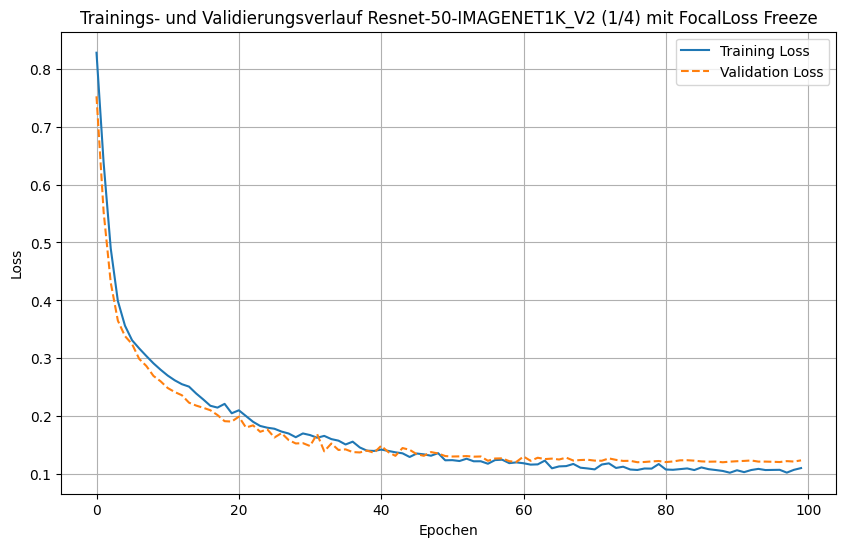

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss', linestyle='--')

plt.title('Trainings- und Validierungsverlauf Resnet-50-IMAGENET1K_V2 (1/4) mit FocalLoss Freeze')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Zeige zufällige Samples an den Indizes: [15, 12, 25]


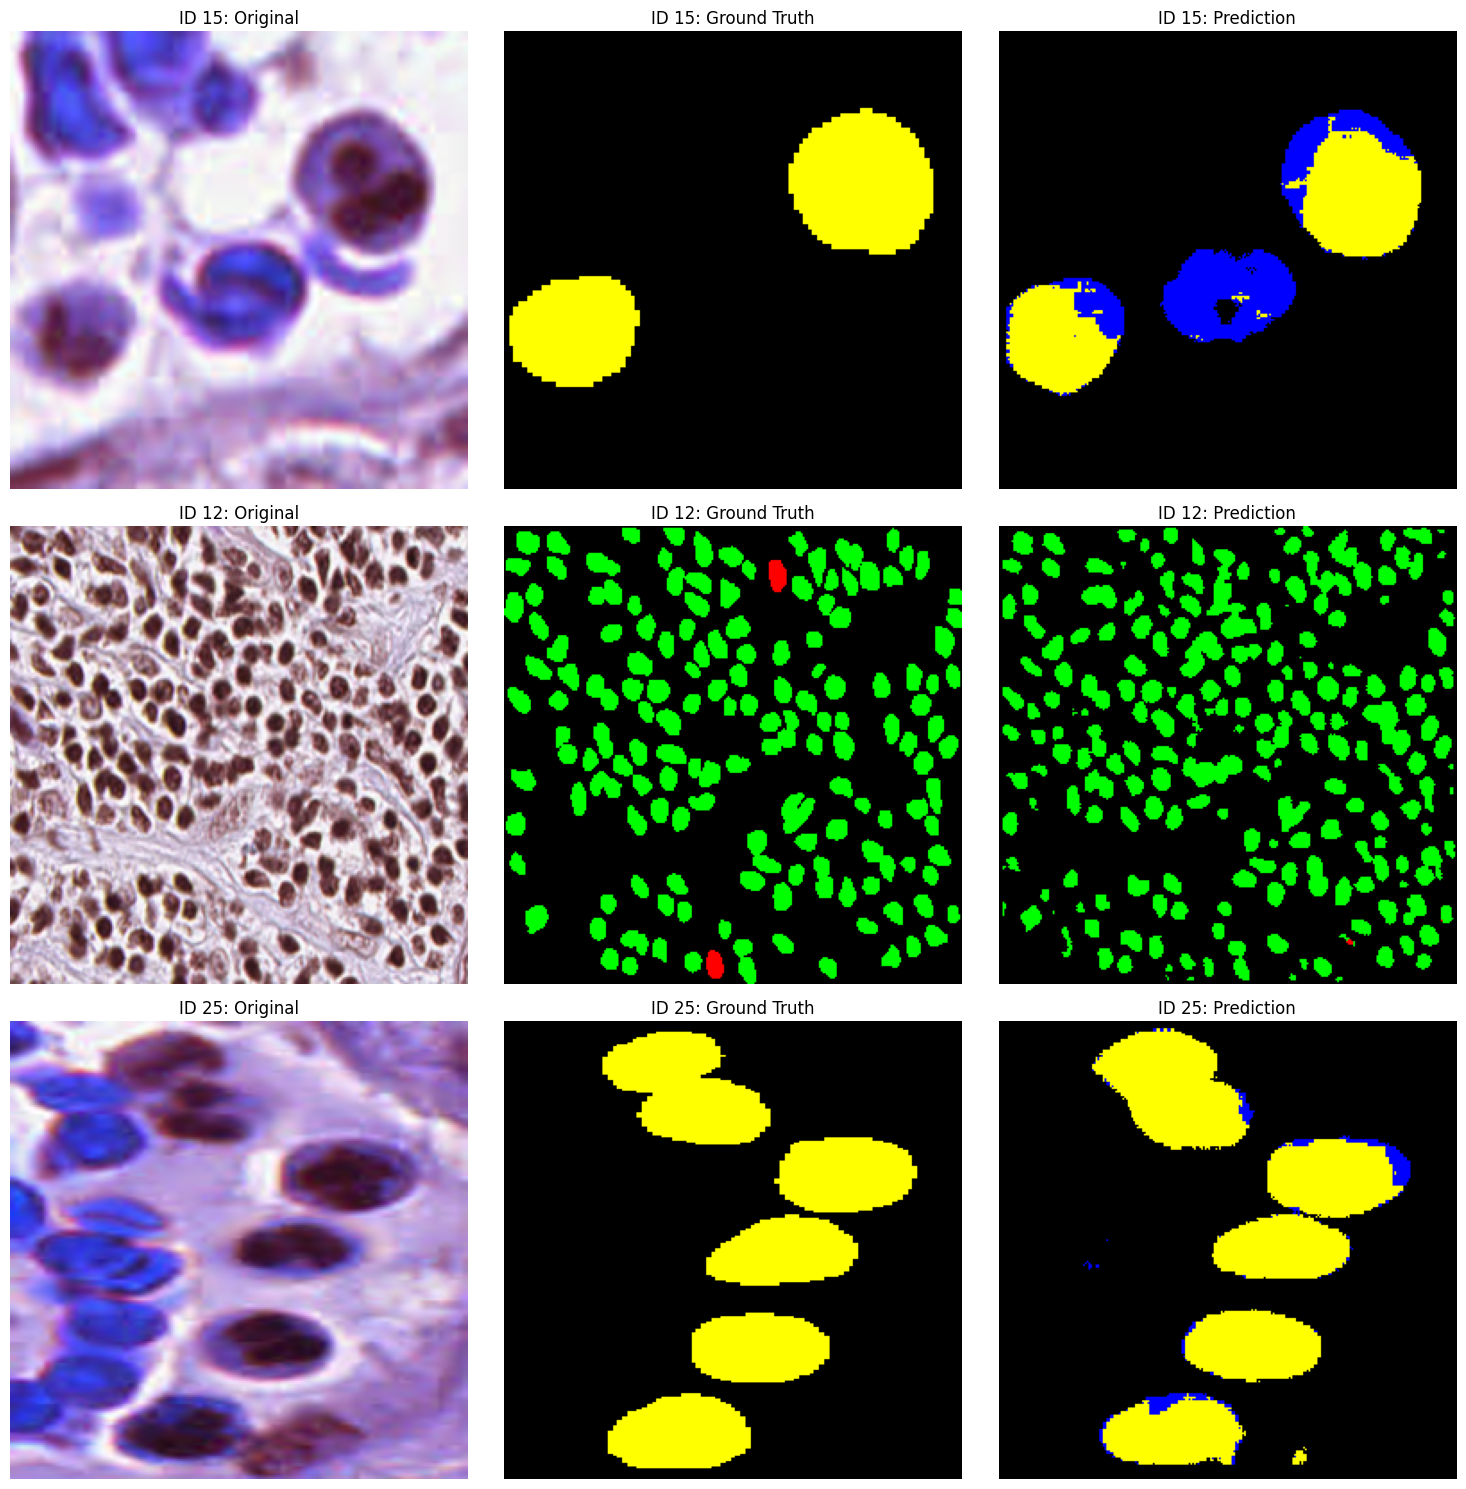

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

class_colors_map = {
    0: np.array([0, 0, 0]),       # Hintergrund: Schwarz
    1: np.array([255, 0, 0]),     # Epithelial: Rot
    2: np.array([0, 255, 0]),     # Lymphocyte: Grün
    3: np.array([0, 0, 255]),     # Macrophage: Blau
    4: np.array([255, 255, 0])    # Neutrophil: Gelb
}

def decode_mask_to_rgb(mask_2d):
    """Wandelt Index-Maske (0-4) in RGB Bild um"""
    h, w = mask_2d.shape
    rgb_image = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in class_colors_map.items():
        rgb_image[mask_2d == class_idx] = color
    return rgb_image

num_samples = 3
model.eval()

total_val_images = len(val_dataset)
# Sicherheit, falls weniger als 3 Bilder da sind
count = min(num_samples, total_val_images)
indices = random.sample(range(total_val_images), count)

print(f"Zeige zufällige Samples an den Indizes: {indices}")

plt.figure(figsize=(15, 5 * count))

for i, idx in enumerate(indices):
    # 1. Daten laden
    img_tensor, mask_tensor = val_dataset[idx]
    
    # 2. Vorhersage machen
    img_input = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_input)
        # Argmax liefert die Klasse mit der höchsten Wahrscheinlichkeit
        prediction_tensor = torch.argmax(output, dim=1).cpu().squeeze(0)

    # 3. Umwandeln für Anzeige (Tensor -> Numpy -> RGB)
    img_display = img_tensor.permute(1, 2, 0).numpy()
    mask_display = decode_mask_to_rgb(mask_tensor.numpy())
    pred_display = decode_mask_to_rgb(prediction_tensor.numpy())

    # 4. Plotten
    # Spalte 1: Original
    plt.subplot(count, 3, i*3 + 1)
    plt.imshow(img_display)
    plt.title(f"ID {idx}: Original")
    plt.axis("off")

    # Spalte 2: Echte Maske
    plt.subplot(count, 3, i*3 + 2)
    plt.imshow(mask_display)
    plt.title(f"ID {idx}: Ground Truth")
    plt.axis("off")

    # Spalte 3: Vorhersage
    plt.subplot(count, 3, i*3 + 3)
    plt.imshow(pred_display)
    plt.title(f"ID {idx}: Prediction")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [21]:
# Erstellt alle predictions
import torch
from torch.utils.data import DataLoader
import numpy as np

model.eval()

# Optional: DataLoader für val_dataset, falls du große Daten hast
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Liste, in der alle Predictions gespeichert werden
all_predictions = []

# Über alle Bilder iterieren
for idx, (img_tensor, mask_tensor) in enumerate(val_dataset):
    # Input für das Modell vorbereiten
    img_input = img_tensor.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_input)
        # Argmax liefert die Klasse mit der höchsten Wahrscheinlichkeit
        prediction_tensor = torch.argmax(output, dim=1).cpu().squeeze(0)
    
    # In numpy konvertieren
    pred_mask = prediction_tensor.numpy().astype(np.uint8)
    
    # Speichern in Liste
    all_predictions.append((idx, pred_mask))

print(f"Predictions für {len(all_predictions)} Bilder erzeugt.")

Predictions für 42 Bilder erzeugt.


In [22]:
import tifffile as tiff
from skimage.transform import resize
import re
import glob
import numpy

pred_save_dir = 'predicted_masks'
os.makedirs(pred_save_dir, exist_ok=True)

ground_truth_base = 'MoNuSAC_masks'

for i, (idx, prediction_tensor) in enumerate(all_predictions):
    # prediction_tensor ist deine 2D-Klassenmaske (0-4)
    pred_mask = prediction_tensor.astype(np.uint8)
    
    file_number = idx

    gt_matches = glob.glob(os.path.join(ground_truth_base, '**', f'*{file_number}*.tif'), recursive=True)
    if not gt_matches:
        print(f"Ground truth fehlt für {file_number}")
        # trotzdem speichern ohne Skalierung
        save_path = os.path.join(pred_save_dir, f"pred_{file_number}.tif")
        tiff.imwrite(save_path, pred_mask)
        continue

    gt_path = gt_matches[0]
    ground_truth_shape = tiff.imread(gt_path).shape

    # Prediction auf Ground Truth Größe skalieren
    if pred_mask.shape != ground_truth_shape:
        pred_mask = resize(pred_mask, ground_truth_shape, order=0, preserve_range=True, anti_aliasing=False)
        pred_mask = pred_mask.astype(np.uint8)

    save_path = os.path.join(pred_save_dir, f"pred_{idx}.tif")
    tiff.imwrite(save_path, pred_mask)
    print(f"Prediction gespeichert: {save_path}")


Prediction gespeichert: predicted_masks\pred_0.tif
Prediction gespeichert: predicted_masks\pred_1.tif
Prediction gespeichert: predicted_masks\pred_2.tif
Prediction gespeichert: predicted_masks\pred_3.tif
Prediction gespeichert: predicted_masks\pred_4.tif
Prediction gespeichert: predicted_masks\pred_5.tif
Prediction gespeichert: predicted_masks\pred_6.tif
Prediction gespeichert: predicted_masks\pred_7.tif
Prediction gespeichert: predicted_masks\pred_8.tif
Prediction gespeichert: predicted_masks\pred_9.tif
Prediction gespeichert: predicted_masks\pred_10.tif
Prediction gespeichert: predicted_masks\pred_11.tif
Prediction gespeichert: predicted_masks\pred_12.tif
Prediction gespeichert: predicted_masks\pred_13.tif
Prediction gespeichert: predicted_masks\pred_14.tif
Prediction gespeichert: predicted_masks\pred_15.tif
Prediction gespeichert: predicted_masks\pred_16.tif
Prediction gespeichert: predicted_masks\pred_17.tif
Prediction gespeichert: predicted_masks\pred_18.tif
Prediction gespeichert